In [4]:
from scipy.cluster.vq import kmeans, kmeans2
import matplotlib.pyplot as plt
import qmcpy as qp
from sklearn.cluster import KMeans
import random
import json
import numpy as np
import cv2
import os
import sys
from scipy.spatial import distance
from scipy.spatial import Voronoi, voronoi_plot_2d
cv2.__version__
from sklearn import metrics
import pandas as pd
from scipy.spatial.distance import cdist
from matplotlib.pyplot import figure

# чтение файла

In [5]:
csv = pd.read_csv('labeling.csv', index_col = 0)
list_files = csv['0'].unique()
np.set_printoptions(threshold=sys.maxsize)
images = []
for file in list_files:
    if (os.path.isfile("endo\\" + file)):
        print(file)
        images.append(cv2.imread("endo\\" + str(file), cv2.IMREAD_COLOR))

100H0011.jpg
100H00055.jpg
100H0001110.jpg
100H0017.jpg
100H0003.jpg
1200H0011.jpg
100H0004.jpg
100H000777.jpg
100H0001.jpg
800H0015.jpg
100H00088.jpg


In [ ]:
c = 0
import time
for row in csv.iterrows():
    c+=1
    cur_img = images[np.where(list_files == row[1][0])[0][0]].copy()#.shape
    
    pts_im, pxl_im = generate_points(cur_img, generate_distance_mask(cur_img))
    mask_clustering, centroids = calculate_clustermask(cur_img, pxl_im, 6)
    cur_img_edges, contours = show_objects(cur_img, mask_clustering, 6)

    figures = json.loads(row[1][1])
    for i in figures:
        f = []
        for j in i:
            f.append([j['x'], j['y']])
        mask1 = cv2.fillPoly(np.zeros((cur_img.shape[0], cur_img.shape[1]), np.uint8), [np.asarray(f)], color=3)
        
        mask_user = cv2.fillPoly(np.zeros((cur_img.shape[0], cur_img.shape[1]), np.uint8), [np.asarray(f)], color=255)
        mask_inside = np.zeros((cur_img.shape[0], cur_img.shape[1]), np.uint8)
        for j in range(0, len(np.unique(mask_clustering))):
            mask_j = np.zeros((cur_img.shape[0], cur_img.shape[1]), np.uint8)
            mask_j[mask_clustering == j] = 255
            mask_j[mask_clustering != j] = 0
            c_j, h_j = cv2.findContours(cv2.bitwise_and(mask_user, mask_j), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
 
            #for cjs in c_j:
               # print(len(np.where(cjs > 0)))
            
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        
        x,y,w,h = cv2.boundingRect(np.asarray(f))
        #cv2.rectangle(cur_img_edges,(x,y),(x+w,y+h),(0,255,0),2)
        rect = cv2.minAreaRect(np.asarray(f))
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        cv2.drawContours(cur_img,[box],0,(0,0,255),2)
        #print('contours')
            
        mask4 = np.zeros(cur_img.shape[:2],np.uint8)
        bgdModel = np.zeros((1,65),np.float64)
        fgdModel = np.zeros((1,65),np.float64)
        
        start = time.time()
        
        (mask5, bgdModel, fgdModel) = cv2.grabCut(cur_img, mask1, cv2.boundingRect(np.asarray(f)), bgdModel, fgdModel, iterCount=1, mode=cv2.GC_INIT_WITH_MASK)
        #mask41 = np.zeros((cur_img.shape[0], cur_img.shape[1]), np.uint8)
        mask5 = np.where((mask5==3)|(mask5==1),0,255).astype('uint8')
        mask5 = cv2.bitwise_not(mask5)
        mask5 = cv2.morphologyEx(mask5, cv2.MORPH_CLOSE, (15,15))
        
        end = time.time()
        print(str(mask1.shape), end = '->')
        
        print("%.2f" % (len(mask1[mask1>0])/(mask1.shape[0]*mask1.shape[1])), end = '->')
        print("%.2f" % (end-start))
        
        contours5, hierarchy = cv2.findContours(mask5, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        cv2.polylines(cur_img, [np.asarray(f)], 1, [0,0,255], 2)
        
        if (len(contours5) > 0):
            json1 = '[['
            for h in range(0, len(hierarchy[0])):
                if (hierarchy[0][h][3] == -1):
                    cv2.polylines(cur_img, [contours5[h]], 1, [255,255,0], 2)
                    #print(len(contours5[h]))
                    for c5 in contours5[h]:
                        for c55 in c5:
                            json1 += '{"x":' + str(c55[0]) + ',"y":' + str(c55[1]) +'},'
                    rect = cv2.minAreaRect(np.asarray(contours5[h]))
                    box = cv2.boxPoints(rect)
                    box = np.int0(box)
                    cv2.drawContours(cur_img,[box],0,(255,255,0),2)
            json1 = json1[:-1]
            json1 += ']]'

    cv2.imwrite('112\\labeling' + str(c) + '_for_' + row[1][0], cur_img) 


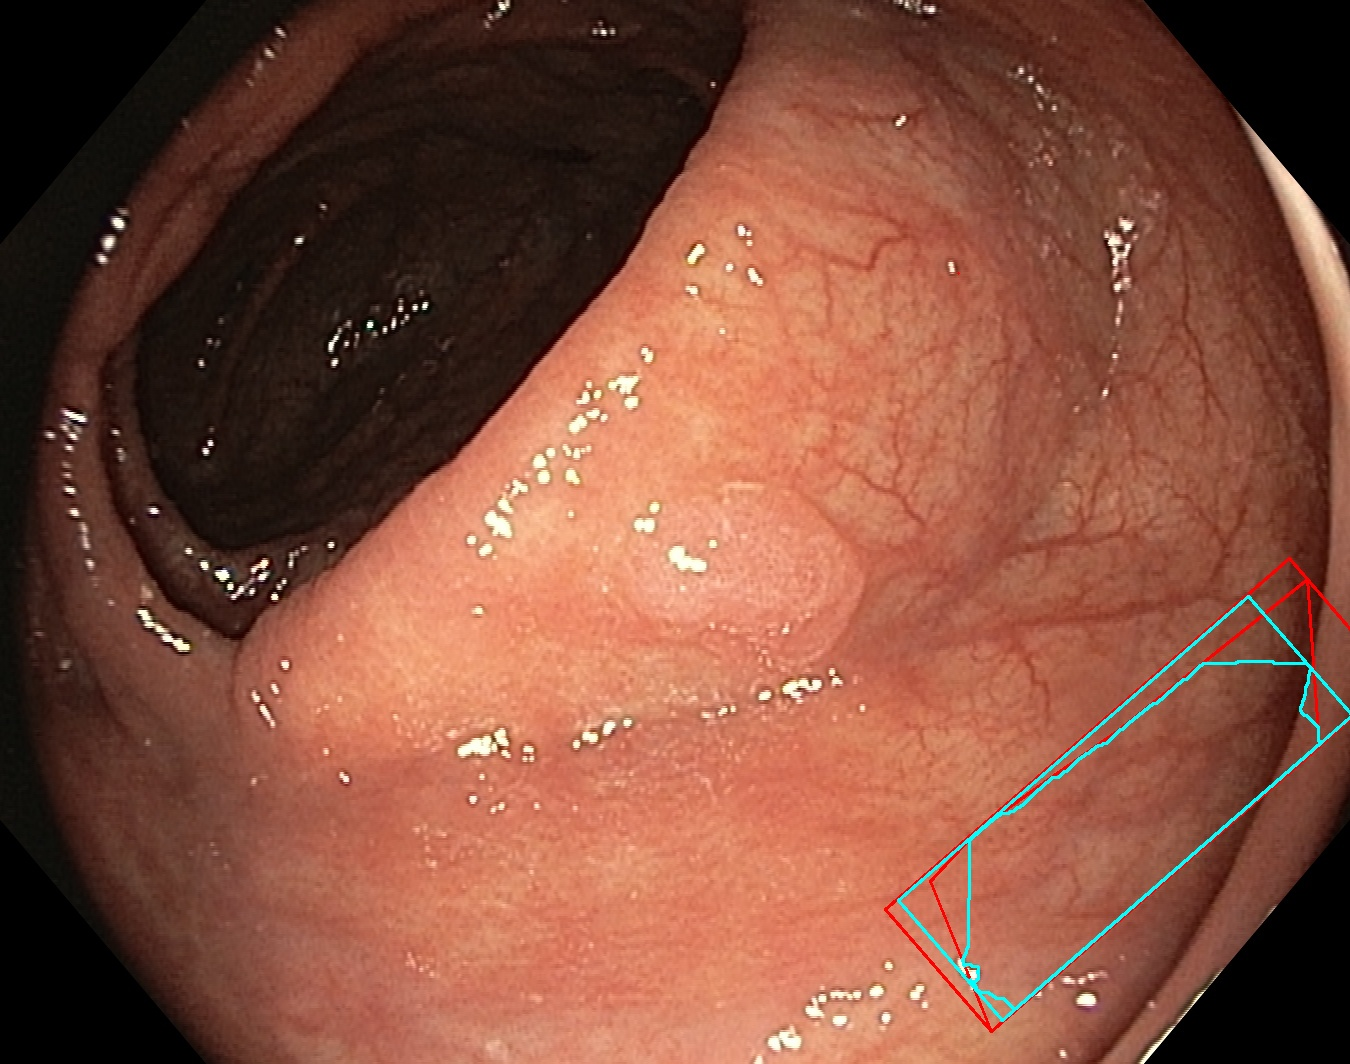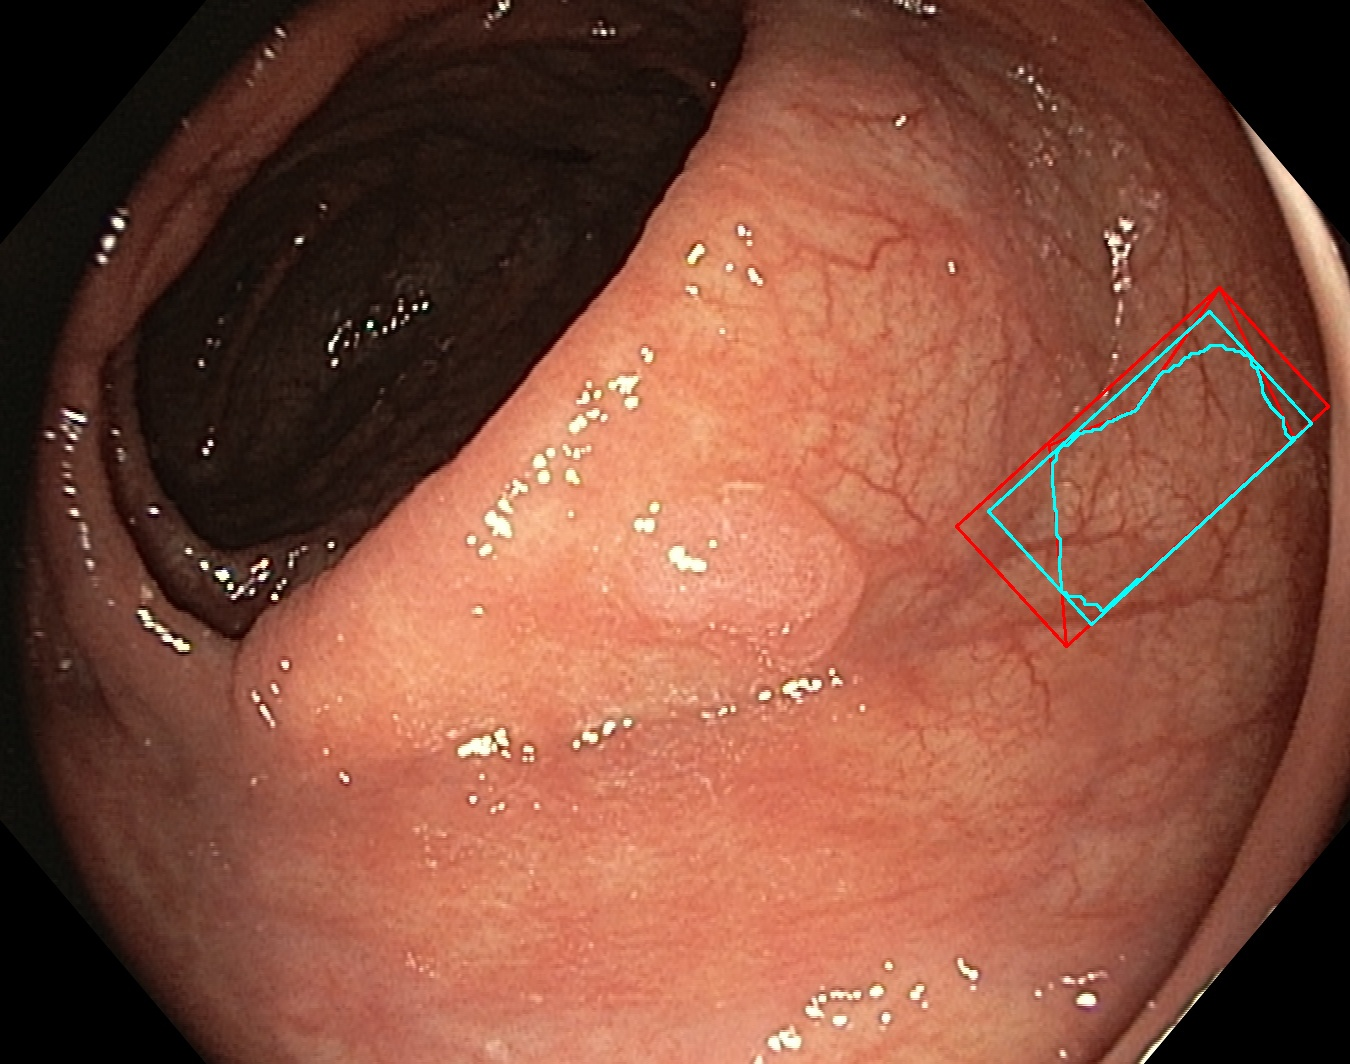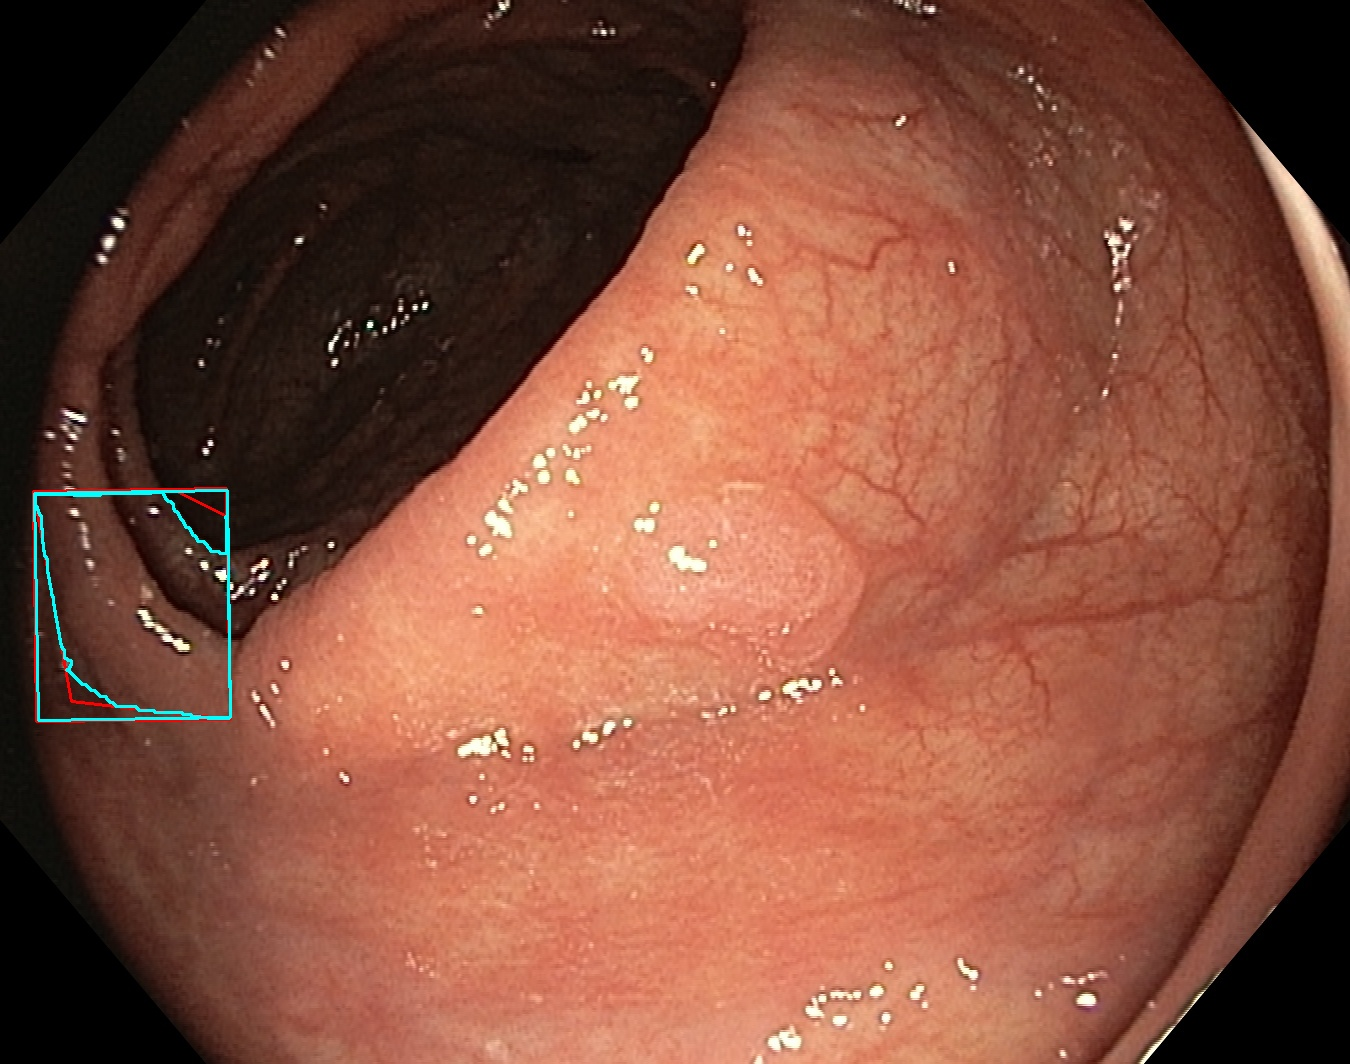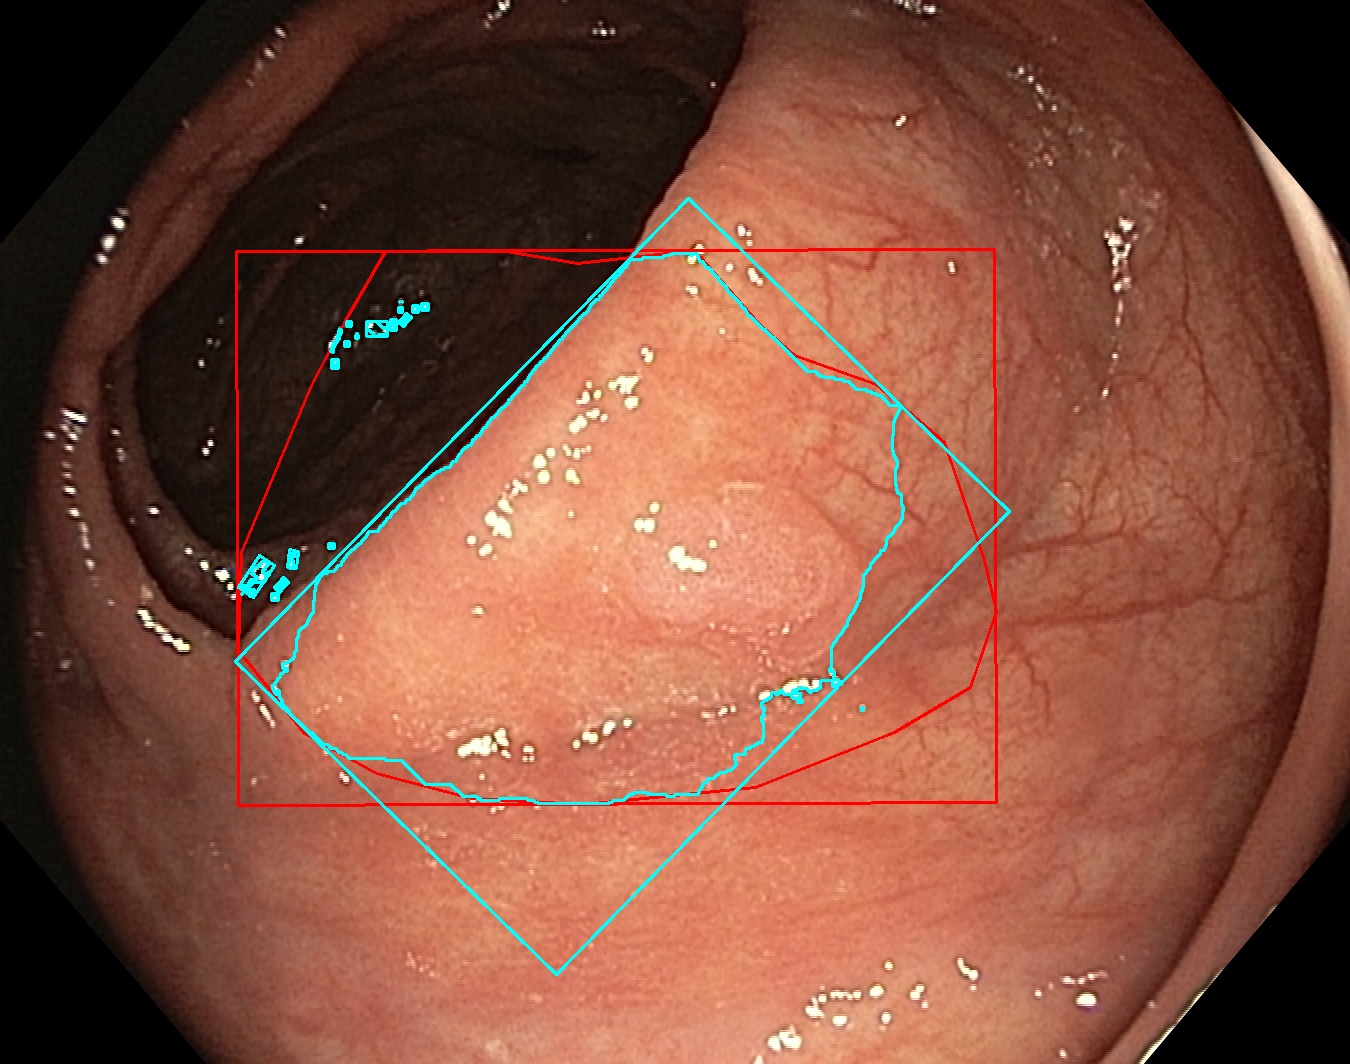

# маска близости-дальности

In [16]:
def generate_distance_mask(im):
    blur = cv2.bilateralFilter(im,9,75,75)

    h,w,chn = blur.shape
    kernel = (19,19)
    edges = cv2.Canny(blur,30,10)

    opening = cv2.morphologyEx(edges, cv2.MORPH_OPEN, kernel)
    edgesf = cv2.bitwise_not(opening)
    dist_img = cv2.distanceTransform(edgesf, cv2.DIST_L2, maskSize=5)
    dist_img[dist_img < 5] = 0
    dist_img[dist_img >= 5] = 255

    
    return dist_img

In [38]:
im = cv2.imread('endo/100H0001.jpg', 3) 

In [39]:
np.shape(generate_distance_mask(im))

(1080, 1350)

# функция, генерирующая точки

In [40]:
 im[0, 0]

array([0, 0, 0], dtype=uint8)

In [41]:
def generate_points(im, dist_img):
    h,w,chn = im.shape
    s = qp.Sobol(dimension=2,randomize=True,graycode=True)
    pts2 = s.gen_samples(80000)
    pts22 = []
    pxl2 = []
    n = 0
    i = 0
    while n < 4000:
        i+=1
        ptsh = int(pts2[i,0] * h)
        ptsw = int(pts2[i,1] * w)
        if ((dist_img[ptsh, ptsw] == 0) and (im[ptsh, ptsw][0] > 0) and (im[ptsh, ptsw][1] > 0) and (im[ptsh, ptsw][2] > 0)):
            n += 1
            ptsi = im[ptsh, ptsw]
            pxl2.append(ptsi)
            pts22.append([ptsh,ptsw])
    pts22 = np.asarray(pts22)#.astype('uint8')
    pts3 = s.gen_samples(20000)
    pts32 = []
    pxl3 = []
    n = 0
    i = 0
    while n < 400:
        i+=1
        ptsh = int(pts3[i,0] * h)
        ptsw = int(pts3[i,1] * w)
        if ((dist_img[ptsh, ptsw] == 255) and (im[ptsh, ptsw][0] > 0) and (im[ptsh, ptsw][1] > 0) and (im[ptsh, ptsw][2] > 0)):
            n += 1
            ptsi = im[ptsh, ptsw]
            pxl3.append(ptsi)
            pts32.append([ptsh,ptsw])
    pts32 = np.asarray(pts32)#.astype('uint8')
    
    pts = np.concatenate((pts22, pts32), axis=0)
    pxl = np.concatenate((pxl2, pxl3), axis=0)
    return pts, pxl

In [43]:
pts_im, pxl_im = generate_points(im, generate_distance_mask(im))
vor = Voronoi(pts_im)
vor

#  мозаика

In [45]:
h,w,chn = im.shape

blank_image = 255*np.ones((h,w,chn), np.uint8)
for i in range(0,len(pts_im)):
    pr = vor.point_region[i]
    pnts = vor.regions[pr]
    pn = []
    for j in range(0,len(pnts)):
        k = pnts[j]
        if (k > 0):
            pn.append(vor.vertices[k].astype('int32'))
    pn = np.asarray(pn)
    for j in range(0,len(pn)):
        c = pn[j,0]
        pn[j,0] = pn[j,1]
        pn[j,1] = c
    #print(pn)
    #cv2.drawContours(blank_image, [pn], -1, (int(pxl[i,0]),int(pxl[i,1]),int(pxl[i,2])), -1)
    #cv2.fillPoly(blank_image, [np.asarray(pn)], (int(pxl_im[i,0]),int(pxl_im[i,1]),int(pxl_im[i,2])), 8)
    cv2.polylines(blank_image, [pn], 1, (255,0,0), 2) 
cv2.imshow('2',blank_image)
filename = 'savedImage.png'
# Saving the image 
cv2.imwrite(filename, blank_image) 
cv2.waitKey(0)
cv2.destroyAllWindows()

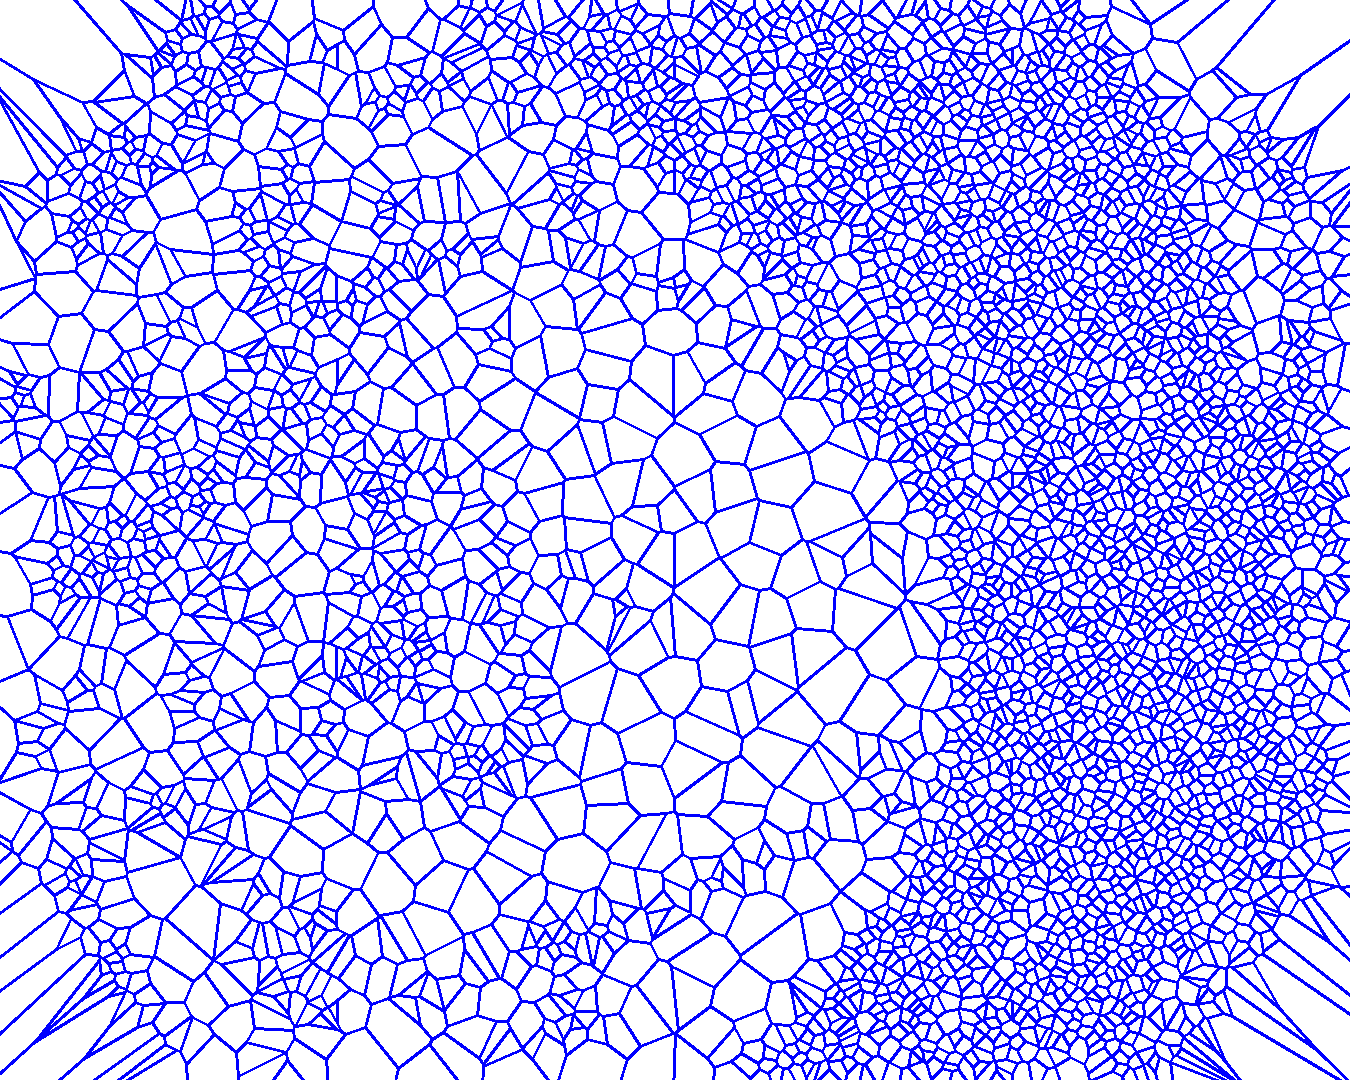

In [48]:
im2 = im.copy()
blur = cv2.blur(im2,(5,5))
n = 8

kmeans = KMeans(n_clusters=n, random_state=0).fit(pxl_im)
values = kmeans.predict(pxl_im[-400:])
print(np.bincount(values)/400)
print(np.unique(values))
print(np.asarray(pxl_im).shape)

centroids = kmeans.cluster_centers_.astype(int)
maskim = generate_distance_mask(im)

for i in centroids:
    print(i)

C:\Users\akhme\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[0.005 0.383 0.03  0.05  0.352 0.03  0.15 ]
[0 1 2 3 4 5 6]
(4400, 3)
[137 149 167]
[ 55  74 131]
[105 115 136]
[224 243 250]
[ 95 129 212]
[ 79  87 101]
[40 50 77]
[172 188 207]


# kmeans predict

In [11]:
def calculate_clustermask(im, pxl_im, n):
    kmeans = KMeans(n_clusters=n, random_state=0).fit(pxl_im)
    centroids = kmeans.cluster_centers_.astype(int)

    blur = cv2.GaussianBlur(im,(5,5), 2)
    mask_clustering = []
   
    for i in range(0, blur.shape[0]):
        mask_clustering.append(kmeans.predict(blur[i,:,:]))
    
    mask_clustering = np.asarray(mask_clustering)
    return mask_clustering, centroids

In [49]:
im2 = im.copy()
pts_im, pxl_im = generate_points(im2, generate_distance_mask(im2))
mask_clustering, centroids = calculate_clustermask(im2, pxl_im, 8)

C:\Users\akhme\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [51]:
blank_image = np.zeros((h,w,chn), np.uint8)
n = 8
for i in range(0,n):
    blank_image[mask_clustering == i] = centroids[i]
cv2.imshow('clusters', blank_image)
filename = 'savedImage.png'
cv2.imwrite(filename, blank_image) 
cv2.waitKey(0) 
cv2.destroyAllWindows() 

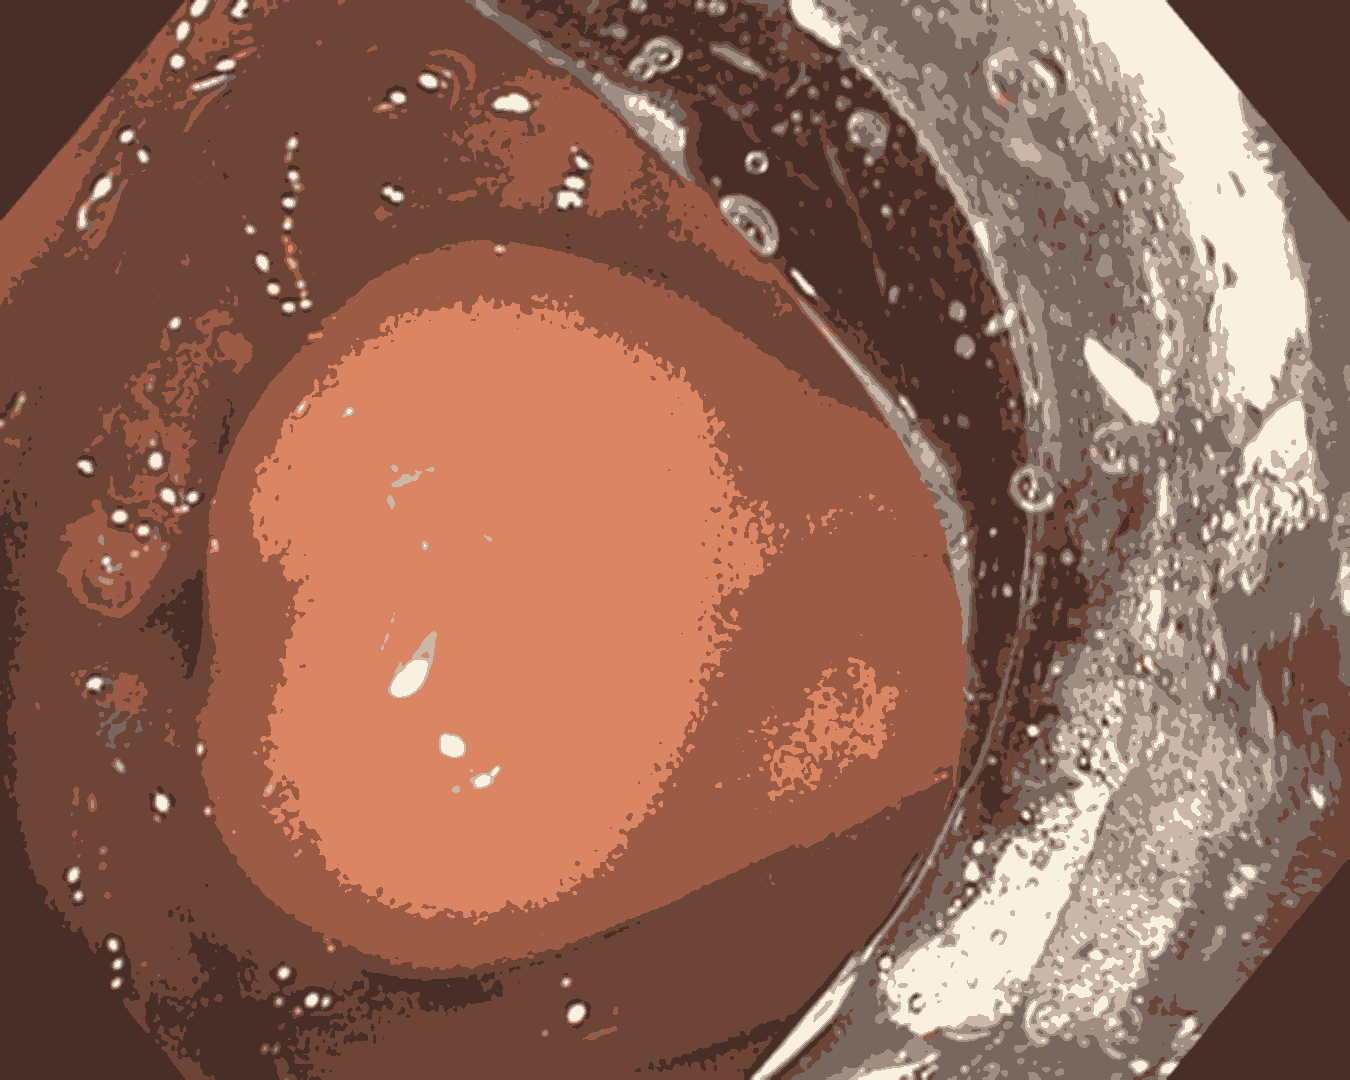

In [14]:
def show_objects(im, mask_clustering, n):
    c_list = []
    ca4stat = []
    #print(centroids)
    h,w,chn = im.shape
    blank_image = np.zeros((h,w,chn), np.uint8)
    im2 = im.copy()
    for i in range(0,n):
        blank_gr = cv2.cvtColor(blank_image, cv2.COLOR_BGR2GRAY)
        blank_gr[mask_clustering == i] = 255
        blank_gr[mask_clustering != i] = 0
        blank_gr = cv2.GaussianBlur(blank_gr, (7,7), 2)
        contours, hierarchy = cv2.findContours(blank_gr, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        for j in range(0, len(contours)):
            ca4stat.append(cv2.contourArea(contours[j]))
    #print(len(ca4stat))
    st_thresh = np.quantile(ca4stat, .9)
    #print('Threshold = ' + str(st_thresh)) 
    for i in range(0,n):
        blank_gr = cv2.cvtColor(blank_image, cv2.COLOR_BGR2GRAY);
        blank_gr[mask_clustering == i] = 255
        blank_gr[mask_clustering != i] = 0
        
        #blank_gr = cv2.GaussianBlur(blank_gr, (7,7), 2)
        contours, hierarchy = cv2.findContours(blank_gr, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        #print(contours[])
        for j in range(0, len(contours)):
            ca4stat.append(cv2.contourArea(contours[j]))
            if (cv2.contourArea(contours[j]) > st_thresh):
                #hull = cv2.convexHull(contours[j])
                #epsilon = 0.00025*cv2.arcLength(contours[j],True)
                #approx = cv2.approxPolyDP(contours[j],epsilon,True)
                c_list.append(contours[j])
    #print('Contours = ' + str(len(c_list)))

    for i in range(0,len(c_list)):
        bgr = [random.randint(0,255), random.randint(0,255), random.randint(0,255)]
        delta = 255-np.max(bgr)
        bgr1 = [bgr[0] + delta, bgr[1] + delta, bgr[2] + delta] 
        cv2.polylines(im2, [c_list[i]], 1, (int(bgr1[0]), int(bgr1[1]), int(bgr1[2])), 1)
    
    return(im2, c_list)

In [53]:
cv2.imshow('Contours', show_objects(im, mask_clustering, 8)[0])
filename = 'savedImage.png'
cv2.imwrite(filename, show_objects(im, mask_clustering, 8)[0]) 
cv2.waitKey(0) 
cv2.destroyAllWindows()

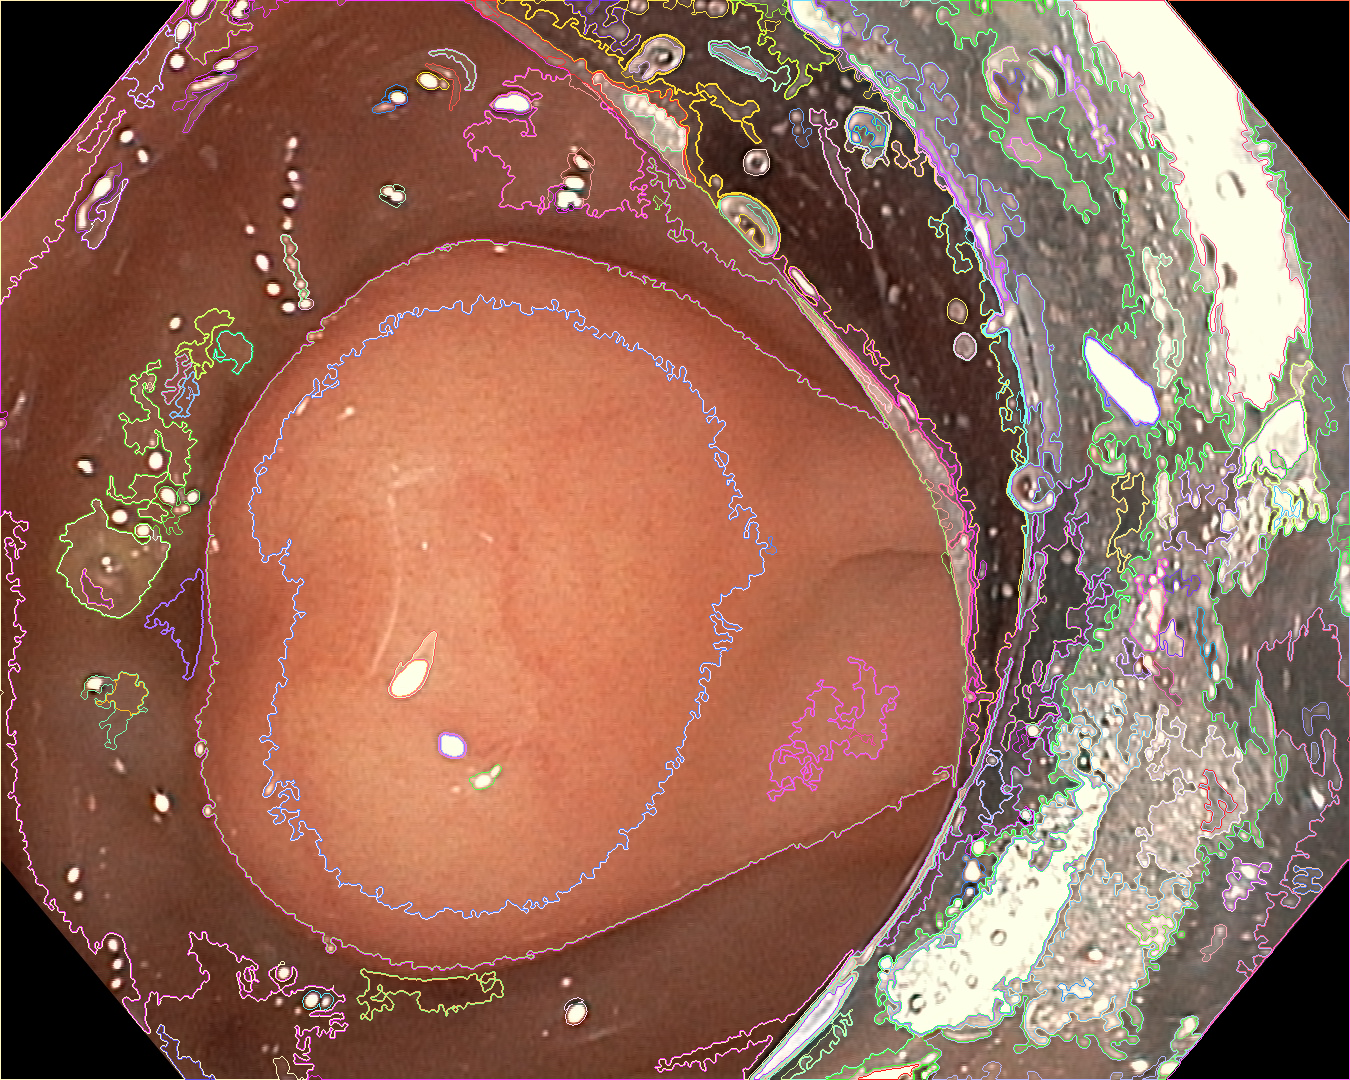